In [2]:
!python -m pip uninstall torch

^C


In [ ]:
!python -m pip install --upgrade pip

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------------------- -------------------- 1.0/2.1 MB 21.8 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 22.2 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# !python -m pip install numml
# !python -m pip install pyamg
!python -m pip install matplotlib

     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     -------------------------------------- 160.4/160.4 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -------- ------------------------------- 1.6/7.6 MB 32.9 MB/s eta 0:00:01
   -------------- ------------------------- 2.7/7.6 MB 28.5 MB/s eta 0:00:01
   -------------------- ------------------- 3.8/7.6 MB 27.2 MB/s eta 0:00:01
   -------------------------- ------------- 5.0/7.6 MB 26.7 MB/s eta 0:00:01
   -------------------------------- ------- 6.2/7.6 MB 26.4 MB/s eta 0:00:01
   -------------------------------------- - 7.4/7.6 MB 26.1 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 25.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/181.9 kB ? eta -:--:--
   ---------------------------------------- 181.9/181.9 kB ? eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------- -

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# !python -m pip install torch
!python -m pip install torch torchvision torchaudio


In [3]:
import torch
print(torch.__config__.show())

PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /bigobj /FS -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE /utf-8 /wd4624 /wd4068 /wd4067 /wd4267 /wd4661 /wd4717 /wd4244 /wd4804 /wd4273, LAPACK_INFO=mkl, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, PERF_WITH_AVX512=1, TORCH_DISABLE_GPU_ASSERTS=OFF, TORCH_VERSION=2.1.2, USE_CUDA=0, USE_CUDNN=OFF, USE_EXCEPTION_PTR=1, USE_GFLAGS=OFF, USE_GLOG=OFF, USE_MKL=ON, USE_MKLDN

problem0.txt
num_nodes: 17
num_edges: 68
num_sinks: 1
num_sources: 1
problem1.txt
num_nodes: 16
num_edges: 118
num_sinks: 1
num_sources: 1
problem2.txt
num_nodes: 13
num_edges: 58
num_sinks: 1
num_sources: 1
problem3.txt
num_nodes: 20
num_edges: 29
num_sinks: 1
num_sources: 1
problem4.txt
num_nodes: 19
num_edges: 95
num_sinks: 1
num_sources: 1
problem5.txt
num_nodes: 18
num_edges: 158
num_sinks: 1
num_sources: 1
problem6.txt
num_nodes: 14
num_edges: 19
num_sinks: 1
num_sources: 1
problem7.txt
num_nodes: 16
num_edges: 40
num_sinks: 1
num_sources: 1
problem8.txt
num_nodes: 15
num_edges: 26
num_sinks: 1
num_sources: 1
problem9.txt
num_nodes: 11
num_edges: 100
num_sinks: 1
num_sources: 1
Finished generating problems!
problem3.txt
Size of the KKT matrix: (217, 217)
Happened for value: True
Running with preconditioner ilu
Iterative solver with preconditioner
problem3.txt
Size of A: (29, 94)
primal error: 0.0
dual error: 265.67837698992366
eta_k: 95.0
total error: 265.67837698992366
Precondit

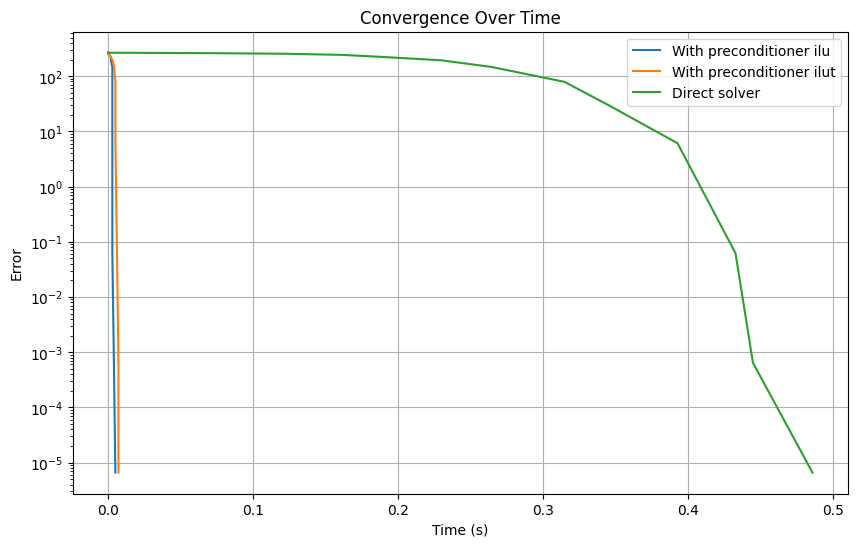

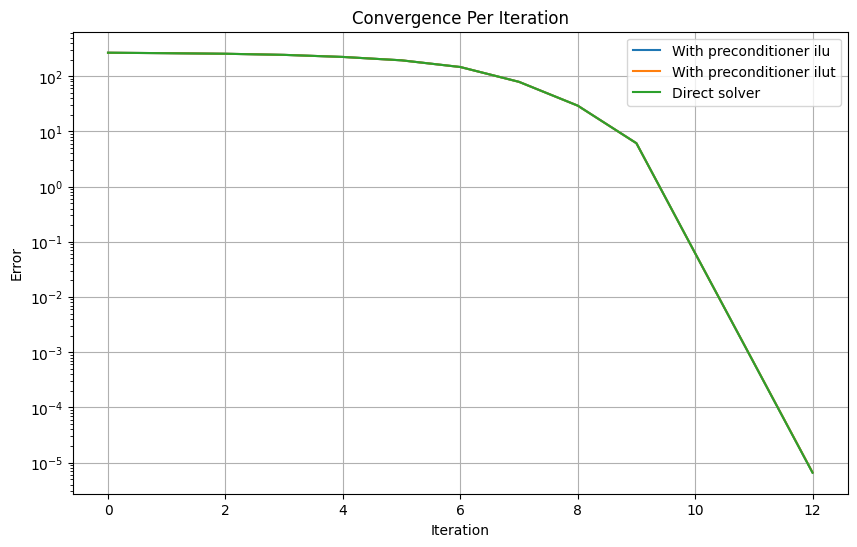

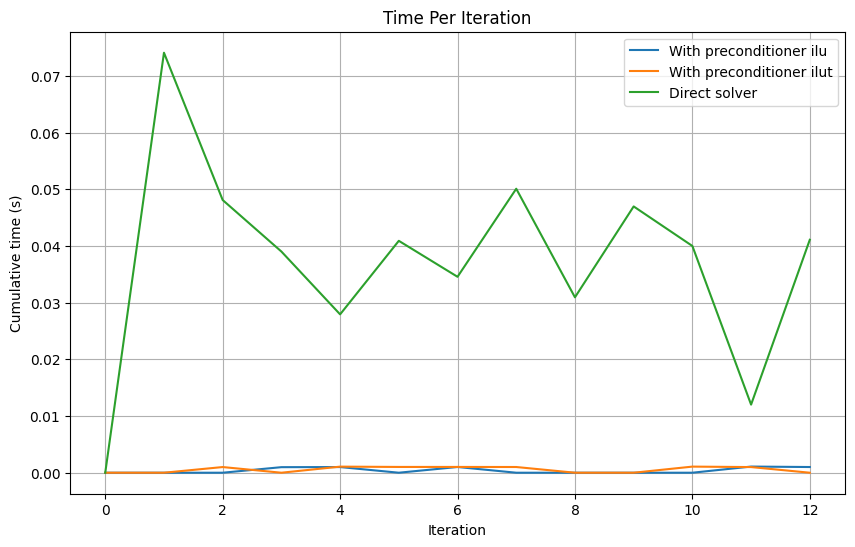

In [7]:
import re
import numpy as np
# import numml as nl
# import ilupp
import torch
import networkx as nx
import pynetgen # see: https://pypi.org/project/pynetgen/
import cvxpy as cvx
import scipy.sparse as sp
# from scipy.sparse.linalg import scale
from scipy.sparse.csgraph import reverse_cuthill_mckee
import scipy.sparse.linalg as spla

import pyamg
import matplotlib.pyplot as plt

import random
import time


from learning_preconditioners_main.krylov.cg import stopping_criterion, fb_solve, fb_solve_joint, conjugate_gradient, preconditioned_conjugate_gradient
from learning_preconditioners_main.krylov.preconditioner import jacobi_preconditioner

torch.set_default_dtype(torch.float64)

# Max flow problem
def parse_dimacs(filename):
    with open(filename, 'r') as f:
        for l in f:
            x, *y = l.split()

            if x.startswith('p'):
                # problem, nodes, edges
                m, n = re.findall('\d+', l)
                # m number of nodes (r = regular)
                nodes = ["r" for i in range(int(m))]
                # n number of edges
                edges = []

            elif x.startswith('n'):
                _, m , n = l.split()
                # set node to target / sink
                nodes[int(m)-1] = n

            elif x.startswith('a'):
                # start, end, capacity
                s, e, c = re.findall('\d+', l )
                edges.append([int(s)-1, int(e)-1, int(c)])

    # create graph
    g = nx.DiGraph()
    # add nodes
    for i in range(len(nodes)):
        g.add_node(i, name=nodes[i])
    # add edges
    for i, e in enumerate(edges):
        g.add_edge(e[0], e[1], capacity=e[2], idx=i)
    # return the graph
    return g


def generate_graph(seed,fname="problem.txt", num_nodes=50, num_edges=200, num_sinks=1, num_sources=1):
    
    # maxcost = mincost = 1 forces max cut problem
    # rng = 1 uses the random number generator from python

    rng = np.random.RandomState(seed)

    pynetgen.netgen_generate(seed=seed, nodes=num_nodes, density=num_edges, sinks=num_sinks, sources=num_sources,
                             rng=1, maxcost=1, mincost=1, supply=100, mincap=1, maxcap=100, fname=fname)
    return 0


def graph_to_lp(g:nx.DiGraph):
    # TODO: convert the graph to a linear program
    # RETURNS: (A, b, c)
    E = g.number_of_edges()
    V = g.number_of_nodes()
    S = 0
    T = 0
    sink_set = set()
    for node,data in g.nodes(data=True):
        edge_list = list(g.edges(node,data=True))
        if data['name'] == "s" :
            S += 1
        elif data['name'] == 't':
            T += 1
            sink_set.add(node)
    # print(S,T)
    length_of_y = E+V-S-T #this is the number of yv and y uv

    #length of x of the orignal form is the yv + yuv
    #for the normal form, each free variable should be substitude by two variables minus like a - b
    # while all y_uv are non negative and all y_v are free, the length should be length of y + V-S-T
    # then we should add all relax variable for these so the final should be
    #length_of_y + V-S-T +E = length_of_y *2
    c = np.zeros(length_of_y*2)

    #it has E constraints , and the # of variables are 2*length_of_y ,
    # so the shape of A should be
    #[E,length_of_y*2]

    A = np.zeros((E,length_of_y*2))
    x = np.ones(length_of_y*2)
    y = np.zeros(E)
    #length of b should be the number of the inequalities constraints
    b = np.zeros(E)
    for node, data in g.nodes(data=True):
        # print(node)

        edge_list = list(g.edges(node,data=True))
        # print(edge_list)
        for e in edge_list:
            #We want to minimize sum(c(u,v)*y_uv), we can assume the first E variables are y_uv
            #So for each edge we should change the corresponding c to the capacity of this edge
            c[e[-1]['idx']] = e[-1]['capacity']

            #for each yuv
            A[e[-1]['idx']][e[-1]['idx']] = 1

            #relax variable, we put the relax variables after all yuv and yv
            A[e[-1]['idx']][e[-1]['idx']+2*length_of_y-E]=-1


            if data['name'] == 's':
                #since yv are free, we should subsitute it with a-b, so the coefficient of the yv_a,yv_b is 1,-1
                A[e[-1]['idx']][E+2*(e[1]-S)] = 1
                A[e[-1]['idx']][E+2*(e[1]-S)+1] = -1
                #when the edge is from the source, we can set the corresponding initial x to 1
                x[e[-1]['idx']] = 2
                #only the edge from 's' we need to change it to 1
                b[e[-1]['idx']] = 1
                y[e[-1]['idx']] = 1
            elif e[1] in sink_set :
                A[e[-1]['idx']][E+2*(e[0]-S)] = -1
                A[e[-1]['idx']][E+2*(e[0]-S)+1] = 1
                y[e[-1]['idx']] = 1
            else:
                A[e[-1]['idx']][E+2*(e[1]-S)] = 1
                A[e[-1]['idx']][E+2*(e[1]-S)+1] = -1
                A[e[-1]['idx']][E+2*(e[0]-S)] = -1
                A[e[-1]['idx']][E+2*(e[0]-S)+1] = 1
                y[e[-1]['idx']] = 1
        # after this step, each row illustrate the



        # you can check if a node is a source or sink by checking the name
        # data['name'] == 's' or data['name'] == 't'

        # get the edges of the node
        # g.edges(node, data=True)
    return A, b, c, x, y

def is_symmetric(matrix):
    """
    Check if a given matrix is symmetric.

    Parameters:
    matrix (np.ndarray): A numpy array representing the matrix.

    Returns:
    bool: True if the matrix is symmetric, False otherwise.
    """
    # First, ensure the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False

    # Check if matrix is equal to its transpose
    return np.allclose(matrix, matrix.T)

def is_positive_definite(matrix):
    """
    Check if the matrix is positive definite.
    """
    # Ensure the matrix is symmetric
    if not is_symmetric(matrix):
        return False

    # Calculate eigenvalues
    eigenvalues = np.linalg.eigvalsh(matrix)

    # Check if all eigenvalues are positive
    return np.all(eigenvalues > 0)

def quantify_differences(a, b):
    # Convert PyTorch tensor to a NumPy array if necessary
    if torch.is_tensor(b):
        b = b.cpu().numpy()
    if torch.is_tensor(a):
        a = a.cpu().numpy()

    print("Quality checks a:")
    # Count NaN values
    num_nan = np.sum(np.isnan(a))

    # Count infinite values
    num_inf = np.sum(np.isinf(a))
    print(f"a: Length: {len(a)} and Number of inf: {num_inf} and number of NaN: {num_nan}")
    
    # print("Quality checks b:")
    # # Count NaN values
    # num_nan = np.sum(np.isnan(b))

    # # Count infinite values
    # num_inf = np.sum(np.isinf(b))
    # print(f"b: Length: {len(b)} and Number of inf: {num_inf} and number of NaN: {num_nan}")
    
    # Now both a and b are NumPy arrays and can be subtracted
    absolute_difference = np.abs(a - b)
    sum_absolute_difference = np.sum(absolute_difference)
    mean_absolute_difference = np.mean(absolute_difference)
    mse = np.mean((a - b) ** 2)
    rmse = np.sqrt(mse)
    max_difference = np.max(absolute_difference)
    euclidean_distance = np.linalg.norm(a - b)

    return {
        "Sum of Absolute Differences": sum_absolute_difference,
        "Mean Absolute Difference": mean_absolute_difference,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Maximum Difference": max_difference,
        "Euclidean Distance": euclidean_distance
    }

def check_small_values(diagonal, threshold=1e-10):
    is_small = np.abs(diagonal) < threshold
    if np.any(is_small):
        print("Matrix contains very small values on the diagonal.")
        return True
    return False

def adjust_small_values(diagonal, threshold=1e-10):
    # Create a copy of the diagonal to modify
    diagonal_copy = np.copy(diagonal)

    too_small = np.abs(diagonal_copy) < threshold
    diagonal_copy[too_small] = threshold
    return diagonal_copy

def create_perturbation(x, s, mu, iteration, scaling_factor=0.1):
    """
    Creates a perturbation term for the primal-dual algorithm.

    Parameters:
    x (np.array): The current primal variable.
    s (np.array): The current slack variable.
    mu (float): The current estimate of the duality gap.
    iteration (int): The current iteration step.
    scaling_factor (float): A scaling factor for the perturbation.

    Returns:
    np.array: The perturbation term.
    """
    n = len(x)
    e = np.ones(n)

    # Basic perturbation based on the current duality gap and iteration
    basic_perturbation = mu * e * np.exp(-iteration * scaling_factor)

    # Additional scaling based on the norms of x and s
    scale_x = np.linalg.norm(x)
    scale_s = np.linalg.norm(s)
    scaled_perturbation = basic_perturbation * (scale_x + scale_s) / 2

    return scaled_perturbation

def test_feasibility_x(x, A, b, tolerance=1e-6):
    # Test if all elements of x are greater than 0
    all_positive = np.all(x > 0)

    # Test if Ax is approximately equal to b
    Ax = A.dot(x)
    satisfies_Ax_equals_b = np.allclose(Ax, b, atol=tolerance)

    return all_positive, satisfies_Ax_equals_b

def test_feasibility_s(s, lam, A, c, tolerance=1e-6):
    # Check if all elements of s are strictly greater than 0
    all_strictly_positive = np.all(s > 0)

    # Check if s = c - A^T lam
    satisfies_constraint = np.allclose(s, c - A.T @ lam, atol=tolerance)

    return all_strictly_positive, satisfies_constraint

def Alpha(s,x,lam,A,b,c,r,sigma,mu,delta_s,delta_x,delta_lam,al=0.05,beta=0.8):
    alpha_s=[]
    for i in range(x.shape[0]):
        if delta_s[i]<0:
            alpha_s.append(s[i]/-delta_s[i])
    alpha_s.append(np.inf)
    alpha_max = 0.99*min(1,min(alpha_s))

    def error(x,s,lam,A=A,b=b,c=c,mu=mu,sigma=sigma,r=r):
      primal_feasibility_error = np.linalg.norm(A @ x - b)
      dual_feasibility_error = np.linalg.norm(A.T @ lam + s - c)
      e = np.ones(len(x))
      cent_feasibility_error = np.linalg.norm(np.diag(x) @ np.diag(s) @ e - sigma * mu * e +r)
      return np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2 + cent_feasibility_error**2)
    x_,s_,lam_ = x+delta_x*alpha_max,s+delta_s*alpha_max,lam+delta_lam*alpha_max
    
    while (any(x_j<0 for x_j in x_)):
        alpha_max *= beta
        x_,s_,lam_ = x+delta_x*alpha_max,s+delta_s*alpha_max,lam+delta_lam*alpha_max
    while (error(x_,s_,lam_)>(1-al*alpha_max)*error(x,s,lam)):
        alpha_max *= beta
        x_,s_,lam_ = x+delta_x*alpha_max,s+delta_s*alpha_max,lam+delta_lam*alpha_max
    return alpha_max

def not_terminate(x, lam, s, A, b, c, mu, k, max_iterations = 300, tolerance=1e-5):
    # Primal feasibility error: ||Ax - b||
    primal_feasibility_error = np.linalg.norm(A @ x - b)

    # Dual feasibility error: ||\nabla f(x) + \nabla g(x) u + A^{T} v||
    # dual_feasibility_error = np.linalg.norm(c + A.T @ s + lam)
    dual_feasibility_error = np.linalg.norm(A.T @ lam + s - c)
    # dfe = np.linalg.norm(A.T @ lam + s - c)
    # print(f"d2 error: {dfe}")

    # Duality gap error (Derivation in text):
    # c^T*x - b^T*y = x^T*c − x^T*A^T*y (using the fact that: Ax=b)
    # = x^T*(c − A^T*y) (After factoring)
    # = x^T*s (using the fact that: c − A^T*y = s)
    eta_k = mu #np.dot(x, s)
    total_error = np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2)
    print(f"primal error: {primal_feasibility_error}")
    print(f"dual error: {dual_feasibility_error}")
    print(f"eta_k: {eta_k}")
    print(f"total error: {total_error}")
    if(k >= max_iterations and (not (eta_k <= tolerance and np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2) <= tolerance))):
        print("max iterations exceeded, terminating without optimality")
    
    not_terminate = ((not (eta_k <= tolerance and np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2) <= tolerance)) and k <= max_iterations)

    # Stopping criterion
    return total_error, not_terminate


# Pre-conditioners:

def diagonal_preconditioner(A):
    diag = np.diag(A).copy()
    # Ensure no zero or very small values on the diagonal
    diag[diag < 1e-10] = 1e-10
    M_inv = np.diag(1.0 / diag)
    def matvec(x):
        return M_inv @ x
    return spla.LinearOperator(A.shape, matvec=matvec)

def amg_preconditioner(A):
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix is not square. Shape: {}".format(A.shape))
    if np.any(np.isnan(A.data)) or np.any(np.isinf(A.data)):
        raise ValueError("Matrix contains NaN or inf.")
    # Create the AMG hierarchy
    ml = pyamg.ruge_stuben_solver(A)
    
    # Define the preconditioner using the multilevel solver
    def matvec(x):
        return ml.solve(b=x, tol=1e-10)
    
    return spla.LinearOperator(A.shape, matvec=matvec)

def ilu_preconditioner(left_matrix, shift=None):
    if not sp.issparse(left_matrix):
        A = sp.csc_matrix(left_matrix)  # Convert to sparse matrix if it is dense
    else:
        A = left_matrix.asformat('csc')
    
    if(shift != None):
        A = A + shift * sp.eye(A.shape[0], format='csc')
    
    ilu = spla.spilu(A)   # Perform ILU decomposition
    M_inv = spla.LinearOperator(left_matrix.shape, ilu.solve)  # Create a linear operator for the preconditioner
    return M_inv

def ilut_preconditioner(left_matrix, shift=None):
    if not sp.issparse(left_matrix):
        A = sp.csc_matrix(left_matrix)  # Convert to sparse matrix if it is dense
    else:
        A = left_matrix.asformat('csc')
    
    if(shift != None):
        A = A + shift * sp.eye(A.shape[0], format='csc')
    
    ilu = spla.spilu(A, drop_tol=1e-3, fill_factor=20)   # Perform ILU decomposition
    M_inv = spla.LinearOperator(left_matrix.shape, ilu.solve)  # Create a linear operator for the preconditioner
    return M_inv

def sor_preconditioner(A, omega=1.0, iterations=1):
    if not sp.issparse(A):
        A = sp.csr_matrix(A)

    # Extract diagonal, lower, and upper parts of A
    D = sp.diags(A.diagonal())
    L = sp.tril(A, -1)
    U = sp.triu(A, 1)

    # Define the SOR iteration as a preconditioning operation
    def sor_solve(b):
        x = np.zeros_like(b)
        for _ in range(iterations):
            for i in range(len(b)):
                sigma = (L @ x + U @ x)[i]
                x[i] = (1 - omega) * x[i] + (omega / D[i, i]) * (b[i] - sigma)
        return x
    
    return spla.LinearOperator(A.shape, matvec=sor_solve)

def gmres_preconditioner(A, tol=1e-5, maxiter=1000):
    # Inner solver function: applies GMRES to approximately solve Ax = b
    def inner_solve(b):
        x, exitCode = spla.gmres(A, b, tol=tol, maxiter=maxiter)
        # if exitCode != 0:
        #     print("Warning: Inner GMRES did not converge to the desired tolerance.")
        return x

    # Wrap the inner solver in a LinearOperator
    M_inv = spla.LinearOperator(A.shape, matvec=inner_solve)
    return M_inv

def spai_preconditioner(A):
    # Use pyamg to create a multilevel solver, which can act like a SPAI preconditioner
    ml = pyamg.smoothed_aggregation_solver(A)

    # The multilevel solver can be used as a preconditioner
    def apply_spai(b):
        return ml.solve(b, tol=1e-10)

    return spla.LinearOperator(A.shape, matvec=apply_spai)

def spectral_shift(matrix, shift=1e-6):
    """
    Apply spectral shift to a matrix.

    Parameters:
    matrix (scipy.sparse matrix or numpy.ndarray): The matrix to be shifted.
    shift (float): The amount by which to shift the spectrum of the matrix.

    Returns:
    scipy.sparse.linalg.LinearOperator: A linear operator representing the shifted matrix.
    """
    if not sp.issparse(matrix):
        A = sp.csc_matrix(matrix)  # Convert to sparse matrix if it is dense
    else:
        A = matrix.asformat('csc')

    # Apply the spectral shift
    A_shifted = A + shift * sp.eye(A.shape[0], format='csc')

    # Create a linear operator for the shifted matrix
    linear_operator = spla.LinearOperator(A_shifted.shape, matvec=lambda x: A_shifted.dot(x))

    return linear_operator


# Matrix pre-processing functions. Aim to improve the matrix properties for numerical computation.
def apply_reordering(A):
    # Ensure A is in CSR format for efficient row manipulation
    A_csr = sp.csr_matrix(A)
    # Get the permutation indices from Reverse Cuthill-McKee
    perm = reverse_cuthill_mckee(A_csr)
    # Apply the permutation to reorder the matrix
    A_reordered = A_csr[perm, :][:, perm]
    return A_reordered, perm

def apply_regularization(A, regularization_factor=1e-6):
    # Add a small value to the diagonal entries to prevent singularity
    n = A.shape[0]
    r = sp.eye(n, format='csr') * regularization_factor
    A_regularized = A + r
    return A_regularized

def apply_scaling(A):
    # Ensure A is in a format that supports element-wise operations, like CSR or CSC
    A = sp.csr_matrix(A)
    
    # Compute the 2-norm for each row and column
    row_norms = np.sqrt(A.power(2).sum(axis=1)).A.flatten()
    col_norms = np.sqrt(A.power(2).sum(axis=0)).A.flatten()
    
    # # Avoid division by zero by setting zero norms to one (or adding regularization)
    row_norms[row_norms == 0] = 1
    col_norms[col_norms == 0] = 1
    
    # Calculate the reciprocal (inverse) of the norms for scaling
    row_scales = np.reciprocal(row_norms)
    col_scales = np.reciprocal(col_norms)
    
    # Construct the scaling matrices for rows and columns
    D_row = sp.diags(row_scales)
    D_col = sp.diags(col_scales)
    
    # Scale the matrix
    A_scaled = D_row @ A @ D_col
    
    return A_scaled, row_scales, col_scales


# Solvers:

def tfqmr_solver(A, b, x0 = None, preconditioner=None, tol=1e-6):
    """
    Solve the linear system Ax = b using TFQMR, with an optional preconditioner.

    Parameters:
    A (np.ndarray or scipy.sparse matrix): The coefficient matrix.
    b (np.ndarray): The right-hand side vector.
    preconditioner (function or None): Function that applies the preconditioner.
                                       If None, no preconditioner is used.

    Returns:
    x (np.ndarray): The solution vector.
    info (int): Convergence information (0 if successful).
    """
    if preconditioner is not None:
        M_inv = preconditioner(A)
        solution, info = spla.tfqmr(A, b, x0 = x0, M=M_inv, tol=tol)
    else:
        solution, info = spla.tfqmr(A, b, x0 = x0, tol=tol)

    return solution, info

def lgmres_solver(A, b, x0 = None, preconditioner=None, tol=1e-6):
    """
    Solve the linear system Ax = b using LGMRES, with an optional preconditioner.

    Parameters:
    A (np.ndarray or scipy.sparse matrix): The coefficient matrix.
    b (np.ndarray): The right-hand side vector.
    preconditioner (function or None): Function that applies the preconditioner.
                                       If None, no preconditioner is used.

    Returns:
    x (np.ndarray): The solution vector.
    info (int): Convergence information (0 if successful).
    """
    if preconditioner is not None:
        M_inv = preconditioner(A)
        solution, info = spla.lgmres(A, b, x0 = x0, M=M_inv, tol=tol)
    else:
        solution, info = spla.lgmres(A, b, x0 = x0, tol=tol)

    return solution, info


def bicgstab_solver(A, b, x0 = None, preconditioner=None, tol=1e-6):
    """
    Solve the linear system Ax = b using BiCGSTAB, with an optional preconditioner.

    Parameters:
    A (np.ndarray): The coefficient matrix.
    b (np.ndarray): The right-hand side vector.
    preconditioner (function or None): Function that applies the preconditioner.
                                       If None, no preconditioner is used.

    Returns:
    x (np.ndarray): The solution vector.
    info (int): Convergence information (0 if successful).
    """
    if preconditioner is not None:
        M_inv = preconditioner(A)
        # M_inv = spla.LinearOperator(A.shape, matvec=preconditioner)
        solution, info = spla.bicgstab(A, b, x0 = x0, M=M_inv, tol=tol)
    else:
        solution, info = spla.bicgstab(A, b, x0 = x0, tol=tol)

    return solution, info


def gmres_solver(A, b, x0=None, A_real = None, s = None, x = None, preconditioner = None, tol = 1e-6, restart = 200, max_iter = 2000):
    if preconditioner is not None:
        if A_real is not None and s is not None and x is not None:
            M_inv = preconditioner(A, A_real, s, x)
        else:
            # M_inv = spla.LinearOperator(A.shape, matvec=preconditioner(A))
            M_inv = preconditioner(A)
        solution, info = spla.gmres(A, b, x0=x0, M=M_inv, restart=restart, maxiter = max_iter, tol=tol)
    else:
        solution, info = spla.gmres(A, b, x0=x0, restart = restart, maxiter = max_iter, tol=tol) # restart=restart,
    return solution, info



def solve(x, lam, s, mu, sigma, A, b, c, r, epsilon = 1e-6, use_preconditioner = True, init_guess = None, method = "ilu"):
    # print("Enter Solve")
    n = len(x)
    m = len(lam)

    # Constructing the matrices for the system of equations
    top_left = np.zeros((m, m))
    top_middle = A
    top_right = np.zeros((m, n))

    middle_left = A.T
    middle_middle = np.zeros((n, n))
    middle_right = np.eye(n)

    bottom_left = np.zeros((n, m))
    bottom_middle = np.diag(s)
    bottom_right = np.diag(x)

    # Constructing the block matrix
    left_matrix = np.block([[top_left, top_middle, top_right],
                            [middle_left, middle_middle, middle_right],
                            [bottom_left, bottom_middle, bottom_right]])

    # print(f"left_matrix is symmetric = {is_symmetric(left_matrix)}")
    # Constructing the right-hand side vector
    e = np.ones(n)
    right_vector = np.concatenate((A@x-b, A.T@lam+s-c, np.diag(x) @ np.diag(s) @ e - sigma * mu * e +r))

    time_function = lambda: time.perf_counter()
    
    # COMPUTE THE PRECONDITIONER
    if(use_preconditioner == True):
        if method == "ilu":
            p_start = time_function()
            prec = ilu_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "ilut":
            p_start = time_function()
            prec = ilut_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "amg":
            p_start = time_function()
            prec = amg_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "sor":
            p_start = time_function()
            prec = sor_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "gmres_preconditioner":
            p_start = time_function()
            prec = gmres_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "spai":
            p_start = time_function()
            prec = spai_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "diagonal":
            p_start = time_function()
            prec = diagonal_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")
        
        elif method == "spectral":
            p_start = time_function()
            prec = spectral_shift
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif (method == "baseline"):
            # ! just for convenience is not actually used...
            # measured times here are ignored later on
            p_start, p_stop = 0, 0
            # prec = lambda x: x
            prec = None
        else:
            raise NotImplementedError(f"Preconditioner {method} not implemented!")
    else:
        # ! just for convenience is not actually used...
        # measured times here are ignored later on
        p_start, p_stop = 0, 0
        prec = None
    
    # elif method == "learned":
    #     data = data.to("cpu")
    #     # p_start = time_function()
        
    #     # matrix obtained from forward pass through the model
    #     # to profile do the following:
    #     # cProfile.runctx("L, U = model(data)", {"model": model, "data": data}, {})
    #     # prec = lambda x: fb_solve(L, U, x)
    #     # p_stop = time_function()
    #     # print(p_stop - p_start)
    #     # exit()
        
    #     L, U = model(data)
        
    #     # Preconditioner implemented using nummel
    #     # L is not lower triangular but contains the same elements in a_ji as i a_ij
    #     # this allows an efficient forward-backward solve
    #     # Ln = sp.SparseCSRTensor(L)
    #     # Un = sp.SparseCSRTensor(L.t())
    #     # Lt = L.transpose()
        
    #     # prec = lambda x: fb_solve_joint(L, x)
    #     prec = lambda x: fb_solve(L, U, x)
    #     # p_stop = time_function()
    
    
    if (not sp.issparse(left_matrix)) and (use_preconditioner != None):
        left_matrix = sp.csr_matrix(left_matrix)
    
    # print("Is left_matrix diagonally dominant?", is_diagonally_dominant(left_matrix))
    # Plot the sparsity pattern
    # plt.spy(left_matrix)
    # plt.title('Sparsity Pattern')
    # plt.show()
    # if(not isinstance(left_matrix, np.ndarray)):
    #     eigenvalues = np.linalg.eigvalsh(left_matrix.toarray())
    # else:
    #     eigenvalues = np.linalg.eigvalsh(left_matrix)
    # # print(f"Is positive definite: {is_positive_definite(left_matrix)}")
    # sorted_indices = np.argsort(np.abs(eigenvalues))
    # five_smallest_indices = sorted_indices[:5]
    # print("Five smallest Eigenvalues:", eigenvalues[five_smallest_indices])

    # print("NaN in left_matrix:", np.isnan(left_matrix).any())
    # print("Inf in left_matrix:", np.isinf(left_matrix).any())

    # print("NaN in right_vector:", np.isnan(-right_vector).any())
    # print("Inf in right_vector:", np.isinf(-right_vector).any())
    
        # errors_preconditioner, solution = preconditioned_conjugate_gradient(ilu_preconditioner, left_matrix, -right_vector, x_true=direct_solution)
    # errors_cg, noprec_solution = conjugate_gradient(left_matrix, -right_vector, x_true=direct_solution)
    
    
    # Parameters
    applyRegularization = False
    applyScaling = False
    applyReordering = False
    regularization_term = 1e-6 #Default value: 1e-6

    lMat = left_matrix
    rVec = right_vector
    if(applyReordering):
        lMat, perm = apply_reordering(lMat)
        rVec = rVec[perm]
    if(applyRegularization):
        lMat = apply_regularization(lMat, regularization_factor = regularization_term)
    if(applyScaling):
        lMat, row_scaling, col_scaling = apply_scaling(lMat)

        # Scale the right-hand side vector b
        rVec = row_scaling * rVec  # Reorder and scale b

    if(use_preconditioner):
        start_time = time.time()        
            
        if(init_guess is None):
            init_guess = np.zeros_like(rVec)
        #Select a solver:
        # xVal, info = gmres_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol = epsilon, restart = 200, max_iter=lMat.shape[0]*10) #
        xVal, info = bicgstab_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol=epsilon)
        # xVal, info = lgmres_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol=epsilon)
        # xVal, info = tfqmr_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol=epsilon)
        # xVal, info = cgs_solver(lMat, -rVec, x0=init_guess, preconditioner = prec, tol=epsilon)
        
        end_time = time.time()
        preconditioned_execution_time = end_time - start_time
        solve_time = preconditioned_execution_time
        print(f"Time to solve with preconditioner {method}: {preconditioned_execution_time}")
    # p_time = (p_stop - p_start)
    # overhead = (preconditioned_execution_time) - (p_time)
    # print(f"Time to calculate preconditioner: {p_time}")
    # print(f"Time to execute with preconditioner: {overhead}")
    elif(use_preconditioner == None):
        # Solving the system of equations
        start_time = time.time()
        solution = np.linalg.solve(left_matrix, -right_vector)
        end_time = time.time()
        direct_execution_time = end_time - start_time
        solve_time = direct_execution_time
        print(f"Time to solve with direct method: {direct_execution_time}")
    else:
        start_time = time.time()
        xVal, info2 = gmres_solver(left_matrix, -right_vector, preconditioner = None, tol=epsilon)
        # xVal, info = bicgstab_solver(left_matrix, -right_vector, preconditioner = None, tol=epsilon)
        # xVal, info = lgmres_solver(left_matrix, -right_vector, x0 = init_guess, preconditioner = None, tol=epsilon)
        # xVal, info = tfqmr_solver(left_matrix, -right_vector, x0 = init_guess, preconditioner = None, tol=epsilon)
        # xVal, info = cgs_solver(left_matrix, -right_vector, x0=init_guess, preconditioner = None, tol=epsilon)
        end_time = time.time()
        noprec_execution_time = end_time - start_time
        solve_time = noprec_execution_time
        print(f"Time to solve without preconditioner: {noprec_execution_time}")
    
    if(use_preconditioner != None):
        if(applyScaling):
            # Unscaled and reorder the solution
            # Apply the inverse of column scaling
            xVal = xVal / col_scaling
        solution = xVal            
        if(applyReordering):
            # Reorder the solution back to the original order
            solution = np.empty_like(xVal)
            solution[perm] = xVal  # Inverse permutation applied here

    # # Count NaN values
    # num_nan = np.sum(np.isnan(solution))

    # # Count infinite values
    # num_inf = np.sum(np.isinf(solution))
    # print(f"Number of inf: {num_inf} and number of NaN: {num_nan}")

    # print("Differences:")
    # differences_direct_prec = quantify_differences(direct_solution, solution)
    # differences_prec_noprec = quantify_differences(noprec_solution, solution)
    # differences_direct_noprec = quantify_differences(direct_solution, noprec_solution)

    # print(np.allclose(solution, direct_solution, rtol=1e-5, atol=1e-7))
    # print(np.allclose(noprec_solution, direct_solution, rtol=1e-5, atol=1e-7))
    # print(np.allclose(noprec_solution, solution, rtol=1e-5, atol=1e-7))

    # Extracting the gradients
    grad_lam = solution[:m]
    grad_x = solution[m:n+m]
    grad_s = solution[n+m:]

    return grad_x, grad_lam, grad_s, solve_time

def primal_dual(x, lam, s, A, b, c, sigma = None, scaling_factor = None, max_iterations=300, tolerance=1e-6, use_preconditioner = True, method = "ilu"):
    n = x.shape[0]
    eta_k = x.dot(s)
    k = 0
    iteration=[k]
    error_per_iteration = []
    time_per_iteration = [0]
    # Hyperparameters
    if(sigma == None):
        sigma = 1 - 0.4/np.sqrt(n) # A value in [0, 1]
    total_error, dont_terminate = not_terminate(x, lam, s, A, b, c, eta_k, k, tolerance = tolerance, max_iterations = max_iterations)
    error_per_iteration.append(total_error)
    while(dont_terminate):

        mu = eta_k/n

        if(scaling_factor == None):
            r = 0
        else:
            r = create_perturbation(x, s, mu, k, scaling_factor)

        

        dx, dlam, ds, solve_time,  = solve(x, lam, s, mu, sigma, A, b, c, r, epsilon=tolerance, use_preconditioner = use_preconditioner, init_guess = np.concatenate((x, lam, s)), method = method)
        alpha = Alpha(s, x, lam, A, b, c, r, sigma, mu, ds, dx, dlam, al=0.05,beta=0.8)


        x, lam, s = x + alpha * dx, lam + alpha * dlam, s + alpha * ds
        eta_k = x.dot(s)/n
        k += 1
        print(k)
        total_error, dont_terminate = not_terminate(x, lam, s, A, b, c, eta_k, k, tolerance = tolerance, max_iterations = max_iterations)
        
        iteration.append(k)
        error_per_iteration.append(total_error)
        time_per_iteration.append(solve_time)
    print("Successfully terminated!")
    return x, lam, s, k, mu, total_error, iteration, error_per_iteration, time_per_iteration





if __name__ == "__main__":
    # Generate problems:
    
    num_iterations = 10
    graph_size = "small"

    graph_sizes = dict(zip(["small", "medium", "large"], [[10, 20, 1, 5], [100, 499, 5, 10], [500, 1500, 10, 25]]))
    [lower_limit, upper_limit, source_sink_lower, source_sink_upper] = graph_sizes[graph_size] 

    for i in range(num_iterations):
        fname = "problem" + str(i) + ".txt"
        print(fname)

        num_nodes = random.randint(lower_limit, upper_limit)  #500

        edges_lower = num_nodes + (source_sink_upper - source_sink_lower) + 1
        edges_upper = num_nodes*10
        num_edges = random.randint(edges_lower, edges_upper)
        num_sinks = 1 #random.randint(source_sink_lower, source_sink_upper)
        num_sources = 1# random.randint(source_sink_lower, source_sink_upper)
        print(f"num_nodes: {num_nodes}")
        print(f"num_edges: {num_edges}")
        print(f"num_sinks: {num_sinks}")
        print(f"num_sources: {num_sources}")
        # generate a graph
        generate_graph(i, fname, num_nodes=num_nodes, num_edges=num_edges, num_sinks=num_sinks, num_sources=num_sources)
    print("Finished generating problems!")

    problem_number = "3" #Select the problem number you want to load
    fname = "problem" + problem_number + ".txt"
    print(fname)
    start_time = time.time()
    # parse the graph for the given problem
    g = parse_dimacs(fname)
    # Derive linear system
    A, b, c, j,k = graph_to_lp(g)
    # Feasible point
    x = j #np.ones(c.shape[0]) # Initial primal variables
    s =  np.ones(c.shape[0])  # Initial slack variables
    lam = k #np.zeros(A.shape[0])  # Initial dual variables

    n = len(x)
    m = len(lam)

    # Constructing the matrices for the system of equations
    top_left = np.zeros((m, m))
    top_middle = A
    top_right = np.zeros((m, n))

    middle_left = A.T
    middle_middle = np.zeros((n, n))
    middle_right = np.eye(n)

    bottom_left = np.zeros((n, m))
    bottom_middle = np.diag(s)
    bottom_right = np.diag(x)

    # Constructing the block matrix
    left_matrix = np.block([[top_left, top_middle, top_right],
                            [middle_left, middle_middle, middle_right],
                            [bottom_left, bottom_middle, bottom_right]])

    print(f"Size of the KKT matrix: {left_matrix.shape}")

    # Solve problems:

    
    # Initialize arrays to store which type of run it was, execution times, number of iterations, errors
    type_of_run_array = []
    execution_times = []
    number_of_iterations_array = []
    errors_array = []
    feasibility_array = []

    detailed_iterations = []
    detailed_errors = []
    detailed_execution_times = []

    failed_preconditioners = []
    # hyperparameter_values = np.arange(0, 1.1, 0.1)
    # hyperparameter_values_r = np.arange(-0.1, 1.1, 0.1)
    # print(hyperparameter_values)

    # Parameters
    preconditioner_values = [True, None] #True = Iterative solver with preconditioner, False = Iterative solver w/o preconditioner, None = Direct solver. Multiple choices possible: [True, False, None]
    tol = 1e-5 #Tolerance parameters for iterative solvers
    max_iterations = 50 #Maximum number of iterations that the primal dual algorithm will be run before terminating.
    methods = ["ilu", "ilut", "amg", "sor", "diagonal"] #"ilu", "ilut", "amg", "sor", "gmres_preconditioner", "spai", "diagonal", "baseline"
    sigma = None
    scaling_factor = None
    plot_per_iteration = True
    plot_per_time = True

    for value in preconditioner_values:
        if(value):
            print(f"Happened for value: {value}")
            for method in methods:
                try:
                    print(f"Running with preconditioner {method}")
                    print("Iterative solver with preconditioner")
                    # Problem to load
                    fname = "problem" + problem_number + ".txt"
                    print(fname)
                    start_time = time.time()
                    # parse the graph for the given problem
                    g = parse_dimacs(fname)
                    # Derive linear system
                    A, b, c, j,k = graph_to_lp(g)
                    # Feasible point
                    x = j #np.ones(c.shape[0]) # Initial primal variables
                    print(f"Size of A: {A.shape}")
                    s =  np.ones(c.shape[0])  # Initial slack variables
                    lam = k #np.zeros(A.shape[0])  # Initial dual variables
                    # tolerances = [10**-i for i in range(4, 16)]
                    optimal_x, optimal_lam, optimal_s, number_of_iterations, mu, total_error, iterations, error_per_iteration, time_per_iteration = primal_dual(x, lam, s, A, b, c, sigma=sigma, scaling_factor=scaling_factor, tolerance=tol, use_preconditioner = value, max_iterations = max_iterations, method=method)
                    strictly_positive, satisfies_Ax_equals_b = test_feasibility_x(optimal_x, A, b, tolerance=1e-8)
                    print(f"Feasibility of strict positivity = {strictly_positive} and satisfied Ax=b is {satisfies_Ax_equals_b}")
                    all_strictly_positive, satisfies_constraint = test_feasibility_s(optimal_s, optimal_lam, A, c, tolerance=1e-5)
                    print(f"Feasibility of strict positivity = {all_strictly_positive} and satisfied s=c-A^T lam is {satisfies_constraint}")
                    print(optimal_x.dot(c))
                    end_time = time.time()
                    print(f"Execution time for {value} was {end_time - start_time}")
                    type_of_run_array.append(f"With preconditioner {method}")
                    execution_times.append(end_time - start_time)
                    number_of_iterations_array.append(number_of_iterations)
                    errors_array.append(total_error)
                    feasibility_array.append(strictly_positive and satisfies_Ax_equals_b and all_strictly_positive and satisfies_constraint)

                    detailed_iterations.append(iterations)
                    detailed_errors.append(error_per_iteration)
                    detailed_execution_times.append(time_per_iteration)
                    print(f"Success with method: {method}")
                except:
                    print(f"Failed with preconditioner: {method}")
                    failed_preconditioners.append(method)
        else:
            if(value == False):
                print("Iterative solver with preconditioner")
            elif(not value):
                print("Direct solver")
        
            # Problem to load
            fname = "problem" + problem_number + ".txt"
            print(fname)
            start_time = time.time()
            # parse the graph for the given problem
            g = parse_dimacs(fname)
            # Derive linear system
            A, b, c, j,k = graph_to_lp(g)
            # Feasible point
            x = j #np.ones(c.shape[0]) # Initial primal variables
            print(f"Size of A: {A.shape}")
            s =  np.ones(c.shape[0])  # Initial slack variables
            lam = k #np.zeros(A.shape[0])  # Initial dual variables
            # tolerances = [10**-i for i in range(4, 16)]
            optimal_x, optimal_lam, optimal_s, number_of_iterations, mu, total_error, iterations, error_per_iteration, time_per_iteration = primal_dual(x, lam, s, A, b, c, sigma=sigma, scaling_factor=scaling_factor, tolerance=tol, use_preconditioner = value, max_iterations = max_iterations)
            strictly_positive, satisfies_Ax_equals_b = test_feasibility_x(optimal_x, A, b, tolerance=1e-8)
            print(f"Feasibility of strict positivity = {strictly_positive} and satisfied Ax=b is {satisfies_Ax_equals_b}")
            all_strictly_positive, satisfies_constraint = test_feasibility_s(optimal_s, optimal_lam, A, c, tolerance=1e-5)
            print(f"Feasibility of strict positivity = {all_strictly_positive} and satisfied s=c-A^T lam is {satisfies_constraint}")
            print(optimal_x.dot(c))
            end_time = time.time()
            print(f"Execution time for {value} was {end_time - start_time}")
            if(value == False):
                type_of_run_array.append("Without preconditioner")
                
            elif(not value):
                type_of_run_array.append("Direct solver")
                
            execution_times.append(end_time - start_time)
            number_of_iterations_array.append(number_of_iterations)
            errors_array.append(total_error)
            feasibility_array.append(strictly_positive and satisfies_Ax_equals_b and all_strictly_positive and satisfies_constraint)

            detailed_iterations.append(iterations)
            detailed_errors.append(error_per_iteration)
            detailed_execution_times.append(time_per_iteration)
    print("All runs finished. Summary given below:")
    print(f"Type of runs: {type_of_run_array}")
    print(f"Execution times: {execution_times}")
    print(f"Number of iterations: {number_of_iterations_array}")
    print(f"Errors after finishing: {errors_array}")
    print(f"Feasible assessments: {feasibility_array}")
    print(f"Failed preconditioners: {failed_preconditioners}")

# Plotting
if(plot_per_time):
    plt.figure(figsize=(10, 6))

    for i in range(len(type_of_run_array)):
        # Calculate cumulative time for each algorithm
        cumulative_time = np.cumsum(detailed_execution_times[i])

        # Plotting error vs time
        plt.plot(cumulative_time, detailed_errors[i], label=type_of_run_array[i])

        # # Plotting error vs iteration
        # plt.plot(detailed_iterations[i], detailed_errors[i], label=type_of_run_array[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Error")
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.title("Convergence Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

if(plot_per_iteration):
    plt.figure(figsize=(10, 6))

    for i in range(len(type_of_run_array)):
        # # Calculate cumulative time for each algorithm
        # cumulative_time = np.cumsum(detailed_execution_times[i])

        # # Plotting error vs time
        # plt.plot(cumulative_time, detailed_errors[i], label=type_of_run_array[i])

        # Plotting error vs iteration
        plt.plot(detailed_iterations[i], detailed_errors[i], label=type_of_run_array[i])
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.title("Convergence Per Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))

for i in range(len(type_of_run_array)):
    # Calculate cumulative time for each algorithm
    cumulative_time = np.cumsum(detailed_execution_times[i])

    # # Plotting error vs time
    # plt.plot(cumulative_time, detailed_errors[i], label=type_of_run_array[i])

    # Plotting error vs iteration
    plt.plot(detailed_iterations[i], detailed_execution_times[i], label=type_of_run_array[i])
plt.xlabel("Iteration")
plt.ylabel("Cumulative time (s)")
# plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title("Time Per Iteration")
plt.legend()
plt.grid(True)
plt.show()